Žygimantas Augustas Nemura 2110605 [Strawberry, Bee, Cat]

Atsisiunciame openimage

In [82]:
!pip install openimages

Sukuriame direktorija nuotraukoms ir atsisiunciame jas is openimages

In [83]:
import os
from openimages.download import download_dataset

data_dir = "OpenImages" # Nurodome direktorija
number_for_samples = 400
classes = ["Strawberry", "Bee", "Cat"] # Pasirinktos klases is OpenImages

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

print("Downloading is starting...")
download_dataset(data_dir, classes, limit=number_for_samples) #Atsisiunciame nuotraukas

100%|██████████| 400/400 [00:07<00:00, 53.61it/s]


{'strawberry': {'images_dir': 'OpenImages/strawberry/images'},
 'bee': {'images_dir': 'OpenImages/bee/images'},
 'cat': {'images_dir': 'OpenImages/cat/images'}}

Padalinam duomenis i treniravimo ir testavimo

In [84]:
import random
import shutil

def split_dataset(base_dir, split_ratios=(0.7, 0.2, 0.1)):
    assert abs(sum(split_ratios) - 1.0) < 1e-6
    sets = ['train', 'validate', 'test']

    for cls in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, cls, "images")
        if not os.path.isdir(class_dir):
            continue

        images = [f for f in os.listdir(class_dir) if f.endswith('.jpg')]
        if not images:
            print(f"No images found for class: {cls}")
            continue

        random.shuffle(images)

        total = len(images)
        train_end = int(split_ratios[0] * total)
        val_end = train_end + int(split_ratios[1] * total)

        splits = {
            'train': images[:train_end],
            'validate': images[train_end:val_end],
            'test': images[val_end:]
        }

        for split_name in sets:
            split_dir = os.path.join(base_dir + "_split", split_name, cls)
            os.makedirs(split_dir, exist_ok=True)
            for img in splits[split_name]:
                src = os.path.join(class_dir, img)
                dst = os.path.join(split_dir, img)
                shutil.copy(src, dst)

    print("Split successfully.")

split_dataset(data_dir)

Split successfully.


Su modeliu susijusios bibliotekos

In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

Apsirasome dataset

In [86]:
class Lab2Dataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

Transformacijos

In [87]:
transform = {
    'train': transforms.Compose([ #Treniravimo duomenis truputi paivairinam, kad sumazinti overfitting treniravimo metu
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ]),
    'validation': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ]),
    'test': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
}

Sukuriam datasets

In [88]:
train_dataset = Lab2Dataset(data_dir='OpenImages_split/train', transform = transform['train'])
val_dataset = Lab2Dataset(data_dir='OpenImages_split/validate', transform = transform['validation'])
test_dataset = Lab2Dataset(data_dir='OpenImages_split/test', transform = transform['test'])

Idedam datasets i dataloaders

In [89]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

CNN Modelis

In [90]:
import torch.nn.functional as F

class Lab2CNN(nn.Module):
    def __init__(self, num_classes=3):
        super(Lab2CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) # Tris kartus pritaikom konvoliucija
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2) # Pritaikome pooling

        self.fc1 = nn.Linear(128 * 16 * 16, 512) # Tikimybes
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

        self.dropout1 = nn.Dropout(0.3) # Padeda su overfitting
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x): # Apdoroja duomenis
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)
        x = self.dropout1(F.leaky_relu(self.fc1(x)))
        x = self.dropout2(F.leaky_relu(self.fc2(x)))
        x = self.fc3(x)

        return x

Paruosiam modeli darbui

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Lab2CNN(num_classes=3)
model.to(device)

Lab2CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=3, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)

Cross entropy loss funkcija ir optimizer

In [92]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch - kiek kartu modelis bus treniruojamas, o kitos dvi tuscios aibes skirtos sekti loss per treniravima

In [93]:
num_epoch = 30
train_losses, val_losses = [], []

Treniruojam modeli, sekam loss

In [94]:
for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels) # Palygina spejima su tiesa ir duoda loss
        loss.backward() # Paskaiciuoja nauja gradienta
        optimizer.step() # Atnaujina modelio svorius
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(train_loss)


    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_dataloader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epoch} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

Epoch 1/30 - Train Loss: 2.3503 - Val Loss: 0.6927
Epoch 2/30 - Train Loss: 0.8844 - Val Loss: 0.6443
Epoch 3/30 - Train Loss: 0.7498 - Val Loss: 0.6844
Epoch 4/30 - Train Loss: 0.6674 - Val Loss: 0.5654
Epoch 5/30 - Train Loss: 0.6559 - Val Loss: 0.5404
Epoch 6/30 - Train Loss: 0.6084 - Val Loss: 0.6197
Epoch 7/30 - Train Loss: 0.6111 - Val Loss: 0.5623
Epoch 8/30 - Train Loss: 0.5907 - Val Loss: 0.5438
Epoch 9/30 - Train Loss: 0.5267 - Val Loss: 0.5626
Epoch 10/30 - Train Loss: 0.4751 - Val Loss: 0.6247
Epoch 11/30 - Train Loss: 0.5416 - Val Loss: 0.6541
Epoch 12/30 - Train Loss: 0.5187 - Val Loss: 0.4699
Epoch 13/30 - Train Loss: 0.4730 - Val Loss: 0.4765
Epoch 14/30 - Train Loss: 0.4956 - Val Loss: 0.5014
Epoch 15/30 - Train Loss: 0.4732 - Val Loss: 0.4300
Epoch 16/30 - Train Loss: 0.5175 - Val Loss: 0.4028
Epoch 17/30 - Train Loss: 0.4465 - Val Loss: 0.4520
Epoch 18/30 - Train Loss: 0.4468 - Val Loss: 0.4842
Epoch 19/30 - Train Loss: 0.4404 - Val Loss: 0.6022
Epoch 20/30 - Train L

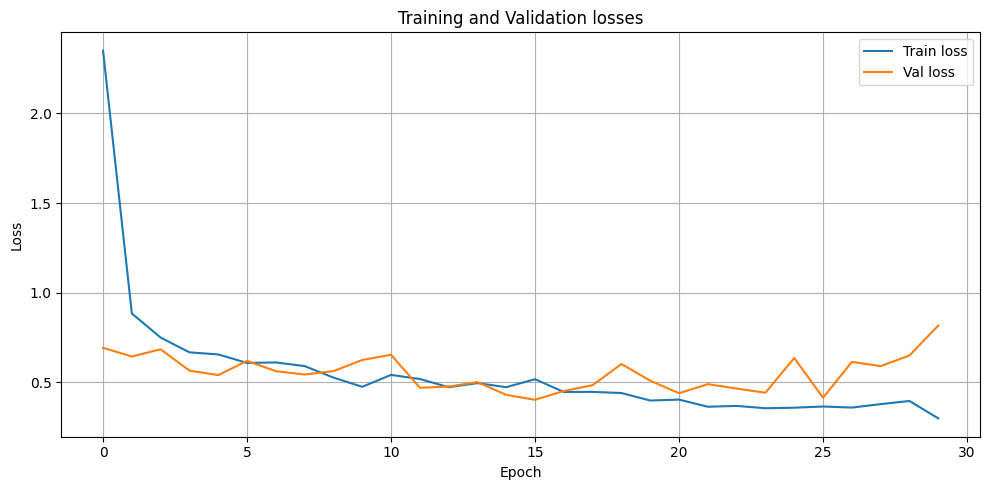

In [95]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train loss')
    plt.plot(val_losses, label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation losses')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_loss(train_losses, val_losses)

Su istreniruotu modeliu testuojam duomenis ir skaiciuojam confusion matrix

In [96]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np


model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


class_labels = test_dataset.classes

conf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precisions = precision_score(y_true, y_pred, average=None)
recalls = recall_score(y_true, y_pred, average=None)
f1s = f1_score(y_true, y_pred, average=None)


print("Confusion Matrix:")
print(conf_matrix)
print(f"\nAccuracy: {accuracy:.4f}\n")

print("Results by class:")
for i, label in enumerate(class_labels):
    print(f"{label}")
    print(f"Precision: {precisions[i]:.4f}")
    print(f"Recall:    {recalls[i]:.4f}")
    print(f"F1:        {f1s[i]:.4f}\n")


Confusion Matrix:
[[36  3  1]
 [13 26  1]
 [ 6  1 33]]

Accuracy: 0.7917

Results by class:
bee
Precision: 0.6545
Recall:    0.9000
F1:        0.7579

cat
Precision: 0.8667
Recall:    0.6500
F1:        0.7429

strawberry
Precision: 0.9429
Recall:    0.8250
F1:        0.8800



Skirta individualiai nuotraukai

In [97]:
from PIL import Image

def predict_single_image(image_path, model, transform, class_names, device):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        _, predicted_idx = torch.max(output, 1)
        predicted_class = class_names[predicted_idx.item()]
        probabilities = torch.softmax(output, dim=1).squeeze().cpu().numpy()

    print(f"Predicted class: {predicted_class}")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {probabilities[i]*100:.2f}%")

    return predicted_class

In [103]:
image_path = "bee.jpg"
predict_single_image(image_path, model, transform['test'], test_dataset.classes, device)

Predicted class: bee
bee: 100.00%
cat: 0.00%
strawberry: 0.00%


'bee'

API stuff

In [99]:
!pip install flask pyngrok

In [100]:
from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route('/predict', methods=['POST']) # Sukuriam nuoroda post metodui
def predict():
    if 'file' not in request.files:
        return jsonify({'error': 'No image file found'}), 400

    file = request.files['file']
    img = Image.open(file.stream).convert('RGB')
    img_tensor = transform['test'](img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        _, pred = torch.max(output, 1)
        probabilities = torch.softmax(output, dim=1).squeeze().cpu().numpy()

    result = { # Rezultatas json formatu
        'predicted_class': test_dataset.classes[pred.item()],
        'probabilities': {cls: float(f"{prob*100:.2f}") for cls, prob in zip(test_dataset.classes, probabilities)}
    }
    return jsonify(result)

In [101]:
from pyngrok import ngrok
from threading import Thread

!ngrok config add-authtoken 2vRUgK8Z6G2bhQjBYnsXjSpISPR_5YDVReGvgQFM56ey7MvJA

ngrok.kill()

public_url = ngrok.connect(5000)
print(f"Public URL: {public_url}")

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Public URL: NgrokTunnel: "https://423d-34-148-73-164.ngrok-free.app" -> "http://localhost:5000"


In [102]:
import requests

url = public_url.public_url + "/predict"
image_path = "bee.jpg"

with open(image_path, 'rb') as img:
    files = {'file': img}
    response = requests.post(url, files=files)

print(response.status_code)
print(response.json())

INFO:werkzeug:127.0.0.1 - - [08/Apr/2025 11:51:25] "POST /predict HTTP/1.1" 200 -


200
{'predicted_class': 'bee', 'probabilities': {'bee': 100.0, 'cat': 0.0, 'strawberry': 0.0}}
